In [1]:
import uproot as up
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import mplhep as hep
hep.style.use(hep.style.CMS)
import ROOT
import numpy as np
import matplotlib.pyplot as plt
from fit_types import fit_unbinned_double_gauss, fit_unbinned_gauss

Welcome to JupyROOT 6.26/10


In [2]:
# open the file
file = up.open("../../analyzer_output.root")

# get the tree
track_events = file["demo/trackTree"]
# events.show()
track_df = track_events.arrays(library='pd')

# gen events
gen_events = file["demo/genTree"]
# gen_events.show()
gen_df = gen_events.arrays(library="pd")


In [3]:
print("After per-selection:")
print(f"Events: {track_df.Event.unique().size}, Phi candidates: {track_df.Phi_mass.size}")

After per-selection:
Events: 719, Phi candidates: 3746


In [4]:
track_df = track_df[track_df.Phi_Vtx_Prob > 0.03]
print("After Prob cut:")
print(f"Events: {track_df.Event.unique().size}, Phi candidates: {track_df.Phi_mass.size}")

After Prob cut:
Events: 616, Phi candidates: 2366


In [5]:
track_df = track_df[track_df.ang_lab_Kp_Km > 0.998]
print("After opening angle cut:")
print(f"Events: {track_df.Event.unique().size}, Phi candidates: {track_df.Phi_mass.size}")

After opening angle cut:
Events: 382, Phi candidates: 577


In [6]:
track_df = track_df[(track_df.Phi_mass > 0.92) & (track_df.Phi_mass < 1.12)]
print("After mass cut:")
print(f"Events: {track_df.Event.unique().size}, Phi candidates: {track_df.Phi_mass.size}")

After mass cut:
Events: 346, Phi candidates: 392


In [7]:
track_df = track_df[(track_df.ang_lab_Kp_Phi > 0.9998) & (track_df.ang_lab_Km_Phi > 0.9998)]
print("After opening angle Phi cut:")
print(f"Events: {track_df.Event.unique().size}, Phi candidates: {track_df.Phi_mass.size}")

After opening angle Phi cut:
Events: 338, Phi candidates: 373


Text(1, 0, 'Phi_inv_mass [GeV]')

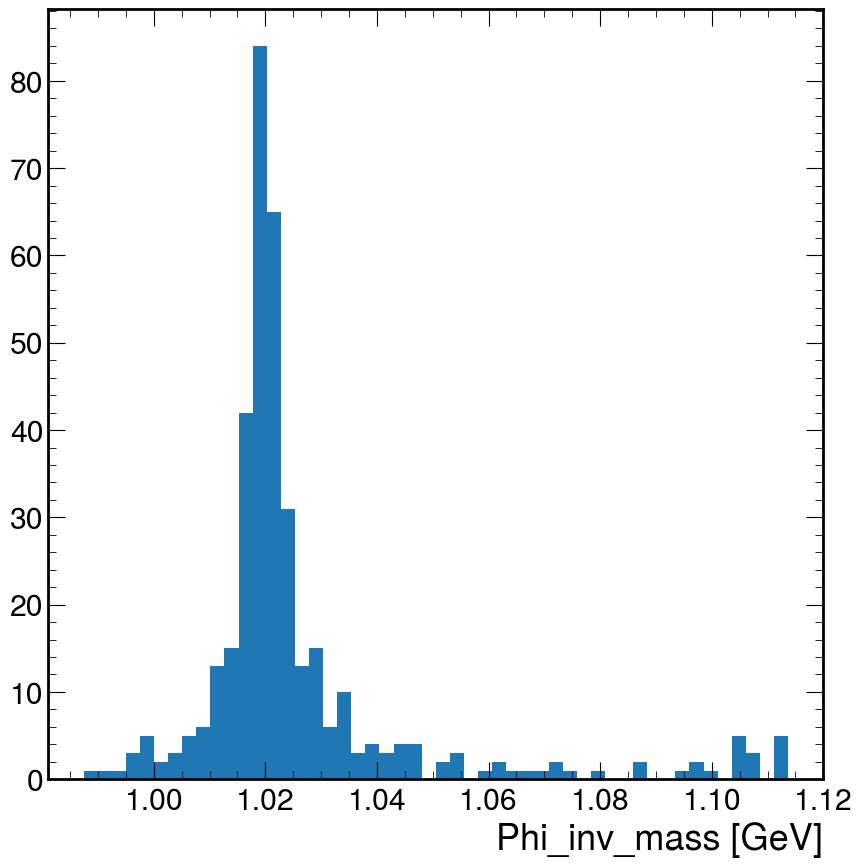

In [8]:
plt.hist(track_df.Phi_mass, bins=50)
plt.xlabel('Phi_inv_mass [GeV]')

Text(0, 1, 'Number of events')

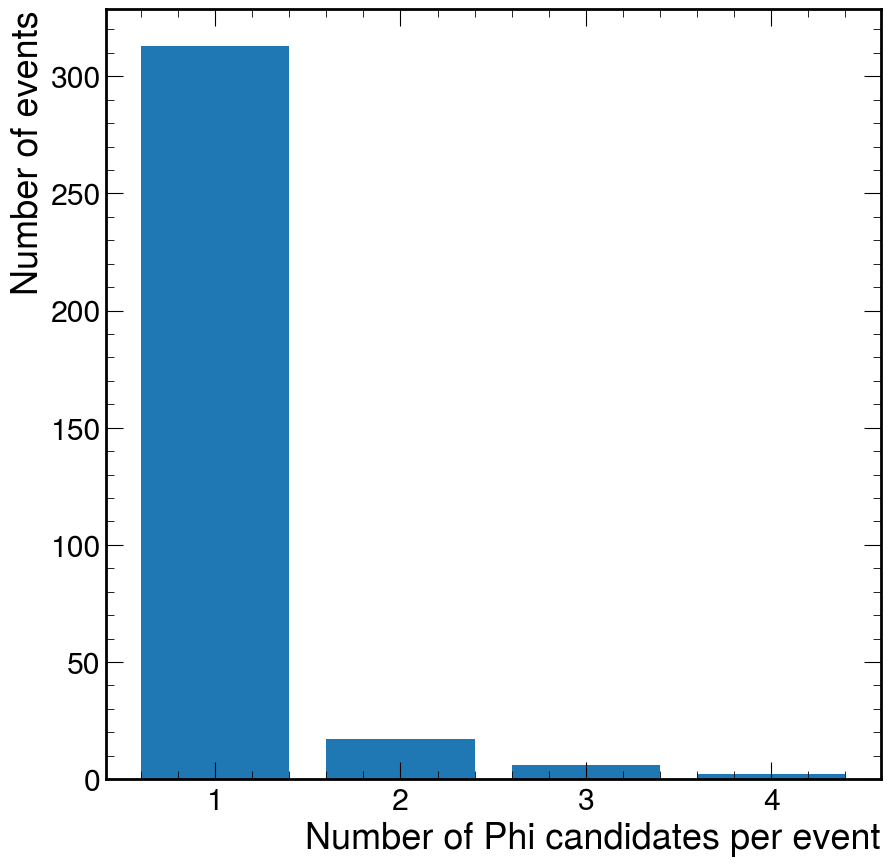

In [9]:
unique, counts = np.unique(track_df.value_counts('Event') , return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Number of Phi candidates per event')
plt.ylabel('Number of events')

In [10]:
# for each event with more than one Z candidate, keep only the one with the highest probability
c = track_df.value_counts('Event')
c = c[c > 1]

indices_to_drop = []
for index in c.index:
    indices_to_drop.append( track_df[(track_df.Event == index) & (track_df.Phi_Vtx_Prob < track_df[track_df.Event == index].Phi_Vtx_Prob.max())].index )

# drop the indices
track_df = track_df.drop(np.concatenate(indices_to_drop))

Text(1, 0, 'Phi_inv_mass [GeV]')

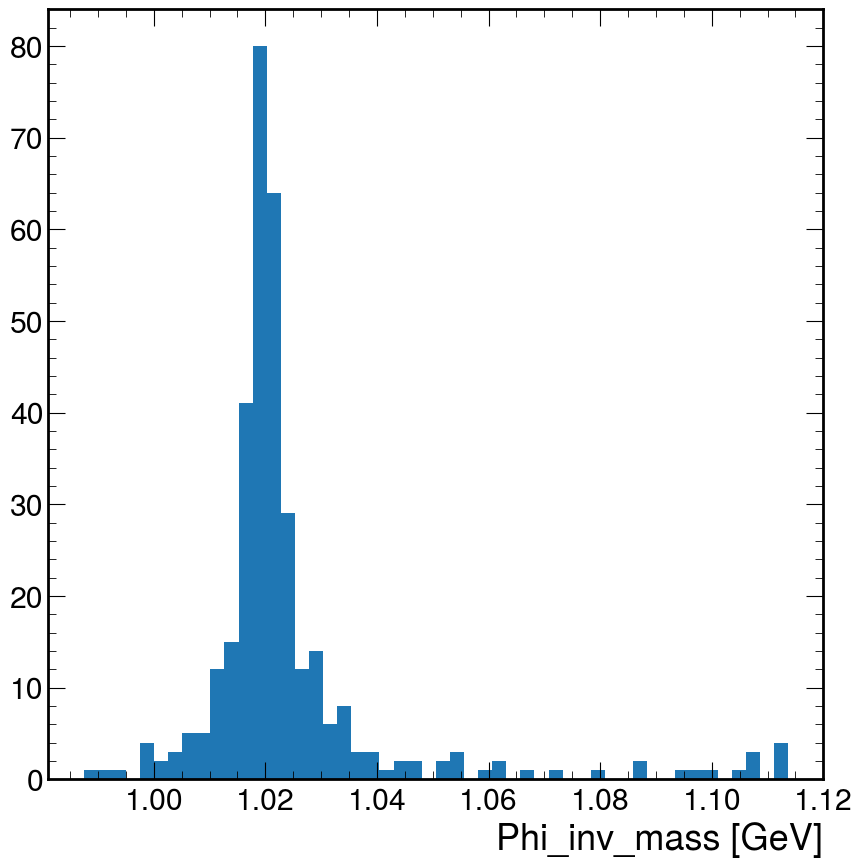

In [11]:
plt.hist(track_df.Phi_mass, bins=50)
plt.xlabel('Phi_inv_mass [GeV]')

In [12]:
print("After dropping extra candidates from the event:")
print(f"Events: {track_df.Event.unique().size}, Phi candidates: {track_df.Phi_mass.size}")

After dropping extra candidates from the event:
Events: 338, Phi candidates: 338


In [19]:
# calulate deltaR between two particles
def deltaR(p1_eta, p2_eta, p1_phi, p2_phi):
    deta = p1_eta - p2_eta
    dphi = p1_phi - p2_phi
    if dphi > np.pi:
        dphi -= 2*np.pi
    if dphi < -np.pi:
        dphi += 2*np.pi
    return np.sqrt(deta*deta + dphi*dphi)

In [20]:
truth_df = track_df.merge(gen_df, on='Event', how='left')

In [21]:
truth_df.columns

Index(['Event', 'Kp_Px', 'Kp_Py', 'Kp_Pz', 'Kp_Pt', 'Kp_Eta', 'Kp_Phi',
       'Kp_charge', 'Km_Px', 'Km_Py', 'Km_Pz', 'Km_Pt', 'Km_Eta', 'Km_Phi',
       'Km_charge', 'Phi_mass', 'Phi_Px', 'Phi_Py', 'Phi_Pz', 'Phi_Pt',
       'Phi_Eta', 'Phi_Phi', 'Phi_Vtx_Prob', 'ang_lab_Kp_Km', 'ang_lab_Kp_Phi',
       'ang_lab_Km_Phi', 'genZ_mass', 'genZ_px', 'genZ_py', 'genZ_pz',
       'genZ_pt', 'genZ_eta', 'genZ_phi', 'genPhi_mass', 'genPhi_px',
       'genPhi_py', 'genPhi_pz', 'genPhi_pt', 'genPhi_eta', 'genPhi_phi',
       'genMuP_pt', 'genMuP_eta', 'genMuP_phi', 'genMuP_charge', 'genMuM_pt',
       'genMuM_eta', 'genMuM_phi', 'genMuM_charge', 'genKp_pt', 'genKp_eta',
       'genKp_phi', 'genKp_charge', 'genKm_pt', 'genKm_eta', 'genKm_phi',
       'genKm_charge'],
      dtype='object')

In [22]:
truth_df['deltaR_Kp'] = truth_df.apply(lambda x: deltaR(x['Kp_Eta'], x['genKp_eta'], x['Kp_Phi'], x['genKp_phi']), axis=1)
truth_df['deltaR_Km'] = truth_df.apply(lambda x: deltaR(x['Km_Eta'], x['genKm_eta'], x['Km_Phi'], x['genKm_phi']), axis=1)

Text(1, 0, 'deltaR')

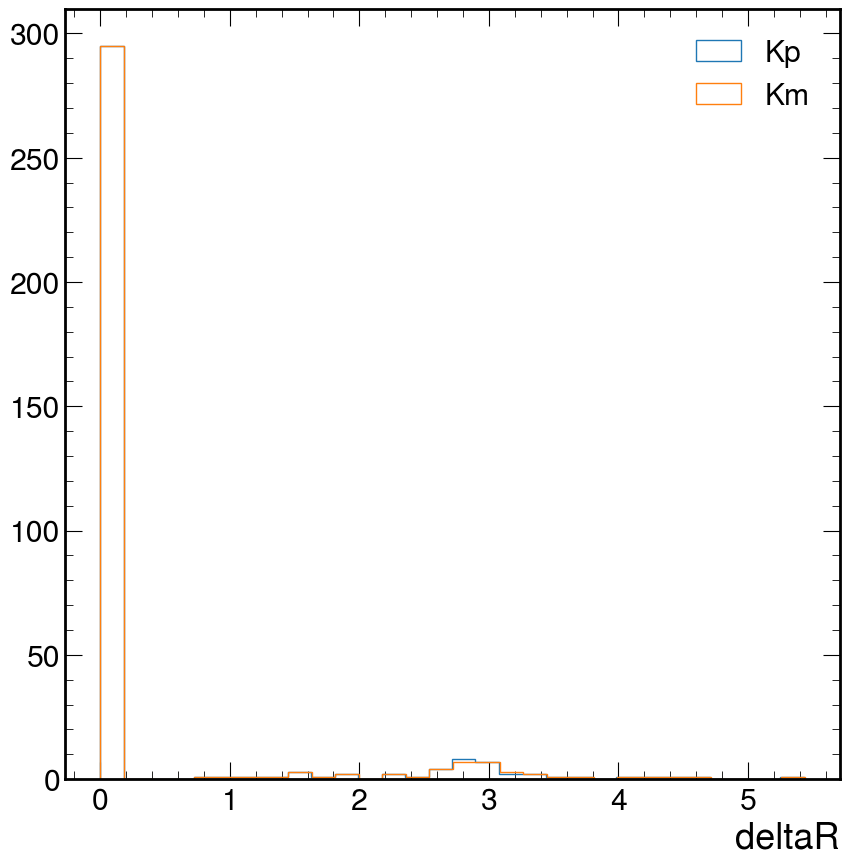

In [23]:
plt.hist(truth_df.deltaR_Kp, bins=30, histtype='step', label='Kp')
plt.hist(truth_df.deltaR_Km, bins=30, histtype='step', label='Km')
plt.legend()
plt.xlabel('deltaR')

In [24]:
# truth match cut
truth_df = truth_df[(truth_df['deltaR_Kp'] < 0.15) & (truth_df['deltaR_Km'] < 0.15)]

Text(1, 0, 'deltaR')

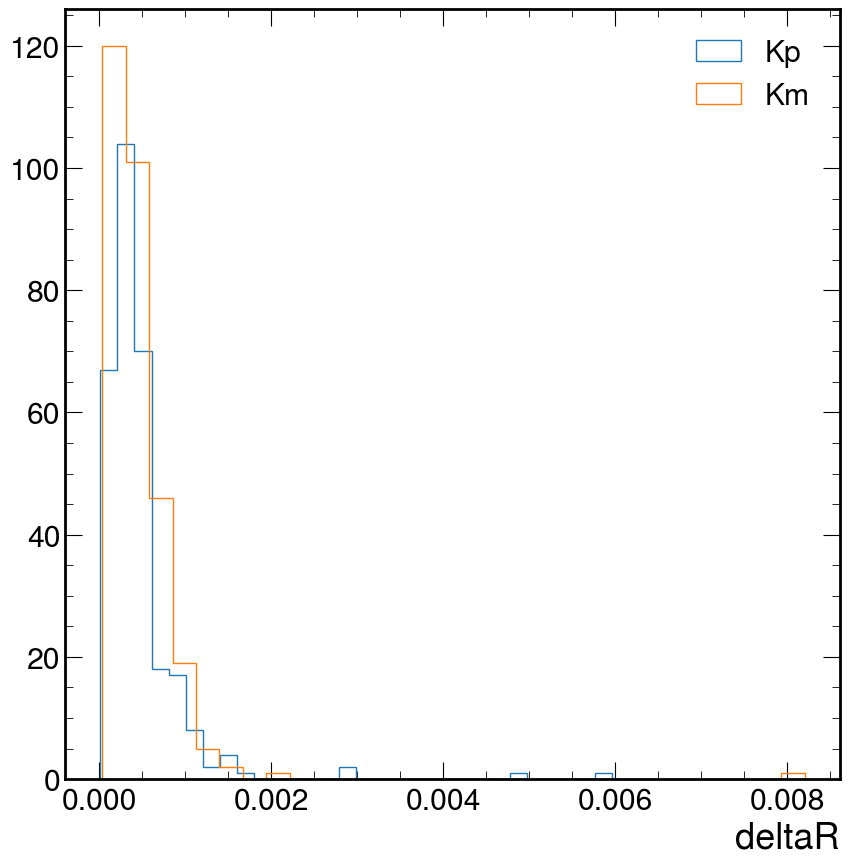

In [26]:
plt.hist(truth_df.deltaR_Kp, bins=30, histtype='step', label='Kp')
plt.hist(truth_df.deltaR_Km, bins=30, histtype='step', label='Km')
plt.legend()
plt.xlabel('deltaR')

In [ ]:
print("After per-selection:")
print(f"Events: {df.Event.unique().size}, Z candidates: {df.Z_mass.size}")

df = df[(df.Z_Vtx_mass >= 70) & (df.Z_Vtx_mass <=110)]
print("After Mass cut:")
print(f"Events: {df.Event.unique().size}, Z candidates: {df.Z_mass.size}")

df = df[(df.Z_Vtx_Prob > 0.03)]
print("After prob cut:")
print(f"Events: {df.Event.unique().size}, Z candidates: {df.Z_mass.size}")

unique, counts = np.unique(df.value_counts('Event') , return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Number of Z candidates per event')
plt.ylabel('Number of events')

# for each event with more than one Z candidate, keep only the one with the highest probability
c = df.value_counts('Event')
c = c[c > 1]

indices_to_drop = []
for index in c.index:
    indices_to_drop.append( df[(df.Event == index) & (df.Z_Vtx_Prob < df[df.Event == index].Z_Vtx_Prob.max())].index )

# drop the indices
df = df.drop(np.concatenate(indices_to_drop))

In [ ]:
Z_candidates = df.Z_Vtx_mass.to_numpy()
Z_mass = ROOT.RooRealVar("Z_mass", "DiMuon invariant Mass", min(Z_candidates), max(Z_candidates), "GeV")
data = ROOT.RooDataSet.from_numpy({f"Z_mass": Z_candidates}, [Z_mass])

In [ ]:
frame = fit_unbinned_gauss(data, Z_mass)
# Draw the frame on the canvas
canvas = ROOT.TCanvas("canvas", "Z Candidates")
frame.Draw()
canvas.Draw()
canvas.SaveAs("Z_candidates.png")

In [ ]:
frame = fit_unbinned_double_gauss(data, Z_mass)
# Draw the frame on the canvas
canvas = ROOT.TCanvas("canvas", "Z Candidates")
frame.Draw()
canvas.Draw()
canvas.SaveAs("Z_candidates_dg.png")

In [ ]:
plt.plot(abs(df['muP_fit_pt']-df['muP_pt']), df['muP_fit_ptError'], '.')
plt.xlabel('muP_fit_pt - muP_pt')
plt.ylabel('muP_fit_ptError')
plt.ylim(-0.1, 10)
plt.xlim(-0.1, 20)
# plt.xlim(-20, 20)

In [ ]:
df[df['muP_fit_eta'] < abs(1)]['muP_fit_ptError']

In [ ]:
plt.hist(df[df['muP_fit_eta'] < abs(1)]['muP_fit_ptError'], range=(0, 6), bins=70)
plt.hist(df[(df['muP_fit_eta'] < abs(2.4)) & (df['muP_fit_eta'] > abs(1.2))]['muP_fit_ptError'], range=(0, 6), bins=70)
plt.xlabel('muP_fit_ptError')
plt.ylabel('Number of events')
plt.legend(['|eta| < 1', '1.2 < |eta| < 2.4'])